# VGG16 Malaria Classification

**Notebook purpose:**  
Two experiments on NIH Malaria `cell_images` dataset using VGG16:
1. Baseline (frozen backbone)  
2. Fine-tune (explicit unfreeze of last N layers)

**Key features:**
- Data augmentation
- Checkpointing and saving best model
- Evaluation with accuracy, precision, recall, F1, AUC
- Confusion matrices, ROC curves, misclassified image visualization


In [1]:
# 1. Setup & imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from glob import glob
import pandas as pd

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


## Dataset Preparation
- Downloads NIH Malaria dataset if not present.
- Prepares training and validation generators with data augmentation.
- Dataset structure: `cell_images/Parasitized/` and `cell_images/Uninfected/`.


In [2]:
# 2. Dataset download (if needed) and generators
if not os.path.exists('cell_images'):
    print('Downloading dataset...')
    os.system('wget -q https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -O cell_images.zip')
    os.system('unzip -q cell_images.zip')

DATASET_DIR = 'cell_images'
assert os.path.exists(DATASET_DIR), "Dataset directory not found."

IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)

CLASS_INDICES = train_generator.class_indices
print('Class indices:', CLASS_INDICES)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Class indices: {'Parasitized': 0, 'Uninfected': 1}


## Utilities
- Functions to build baseline and fine-tuned VGG16 models.
- Functions to plot training history, confusion matrix, ROC curve.
- Evaluation metrics calculation: accuracy, precision, recall, F1-score, ROC-AUC.


In [3]:
# 3. Utilities: model builders, plotting, evaluation
def build_vgg16_baseline(input_shape=IMG_SIZE+(3,), dropout_rate=0.5):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze all layers
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate/2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def build_vgg16_finetune(input_shape=IMG_SIZE+(3,), unfreeze_last_n=4, dropout_rate=0.5):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_last_n:]:
        layer.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate/2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_history(history, title_prefix=''):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].plot(history.history['accuracy'], label='train')
    axes[0].plot(history.history['val_accuracy'], label='val')
    axes[0].set_title(title_prefix + ' Accuracy'); axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Accuracy'); axes[0].legend()
    axes[1].plot(history.history['loss'], label='train')
    axes[1].plot(history.history['val_loss'], label='val')
    axes[1].set_title(title_prefix + ' Loss'); axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss'); axes[1].legend()
    plt.show()

def evaluate_model(model, generator, verbose=1):
    y_prob = model.predict(generator, verbose=verbose)
    y_true = generator.classes
    y_pred = (y_prob.ravel() >= 0.5).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    acc = (y_pred == y_true).mean()
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    return {
        'accuracy': acc, 'precision': precision, 'recall': recall, 'f1_score': f1,
        'roc_auc': roc_auc, 'y_true': y_true, 'y_prob': y_prob.ravel(), 'y_pred': y_pred, 'fpr': fpr, 'tpr': tpr
    }

def plot_confusion(y_true, y_pred, classes=['Parasitized','Uninfected']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix'); plt.colorbar()
    tick_marks = np.arange(len(classes)); plt.xticks(tick_marks, classes, rotation=45); plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j],'d'), horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout(); plt.show()

def plot_roc(fpr, tpr, roc_auc, title='ROC'):
    plt.figure(figsize=(6,5)); plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}'); plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(title); plt.legend(loc='lower right'); plt.show()


## Experiment A — Baseline (VGG16 Frozen)

- Build VGG16 model with all layers frozen (no trainable layers in base model).
- Add custom dense layers on top for binary classification.
- Compile with Adam optimizer and binary crossentropy.
- Track best weights using ModelCheckpoint.



=== Building baseline model (VGG16 frozen) ===
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Baseline model layer trainable flags:
0: input_layer -> trainable=False
1: block1_conv1 -> trainable=False
2: block1_conv2 -> trainable=False
3: block1_pool -> trainable=False
4: block2_conv1 -> trainable=False
5: block2_conv2 -> trainable=False
6: block2_pool -> trainable=False
7: block3_conv1 -> trainable=False
8: block3_conv2 -> trainable=False
9: block3_conv3 -> trainable=False
10: block3_pool -> trainable=False
11: block4_conv1 -> trainable=False
12: block4_conv2 -> trainable=False
13: block4_conv3 -> trainable=False
14: block4_pool -> trainable=False
15: block5_conv1 -> trainable=False
16: block5_conv2 -> trainable=False
17: block5_conv3 -> trainable=False
18: block5_pool -> trainable=False
19: global_average_pooling2d -> trainable=True
20: dense -> trainable=True
21: dropout -> trainable=True
22: dense_1 -> trainable=True
23: dropout_1 -> trainable=True
24: dense_2 -> trainable=Tr

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7660 - loss: 0.8686

689/689 ━━━━━━━━━━━━━━━━━━━━ 185s 253ms/step - accuracy: 0.7661 - loss: 0.8681 - val_accuracy: 0.8887 - val_loss: 0.3089
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8675 - loss: 0.3367

689/689 ━━━━━━━━━━━━━━━━━━━━ 169s 245ms/step - accuracy: 0.8675 - loss: 0.3366 - val_accuracy: 0.8982 - val_loss: 0.2624
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8932 - loss: 0.2737

689/689 ━━━━━━━━━━━━━━━━━━━━ 169s 245ms/step - accuracy: 0.8932 - loss: 0.2737 - val_accuracy: 0.9051 - val_loss: 0.2510
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9086 - loss: 0.2459

689/689 ━━━━━━━━━━━━━━━━━━━━ 167s 243ms/step - accuracy: 0.9086 - loss: 0.2459 - val_accuracy: 0.9049 - val_loss: 0.2436
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9065 - loss: 0.2384

689/689 ━━━━━━━━━━━━━━━━━━━━ 168s 244ms/step - accuracy: 0.9065 - loss: 0.2383 - val_accuracy: 0.9201 - val_loss: 0.2173
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 166s 241ms/step - accuracy: 0.9182 - loss: 0.2177 - val_accuracy: 0.9136 - val_loss: 0.2297
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 167s 242ms/step - accuracy: 0.9196 - loss: 0.2113 - val_accuracy: 0.9160 - val_loss: 0.2256
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 167s 242ms/step - accuracy: 0.9179 - loss: 0.2165 - val_accuracy: 0.9143 - val_loss: 0.2236
Epoch 9/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 167s 243ms/step - accuracy: 0.9239 - loss: 0.2029 - val_accuracy: 0.9114 - val_loss: 0.2265


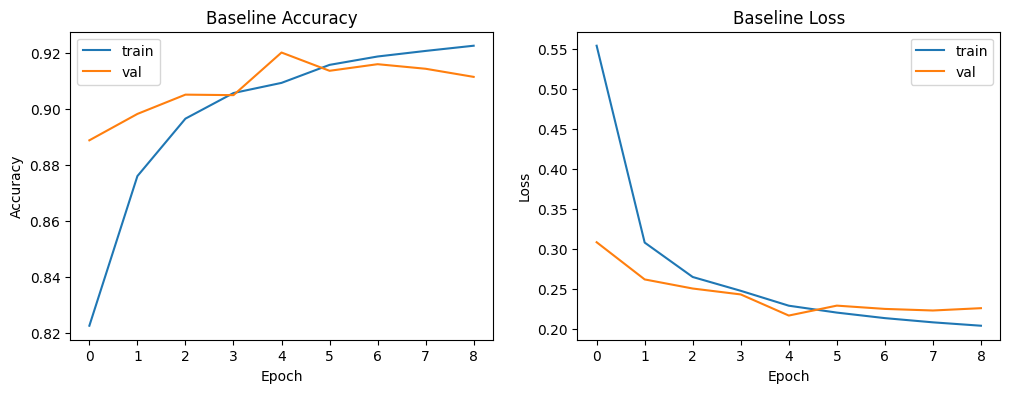

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step

Baseline metrics:
accuracy: 0.9201
precision: 0.8985
recall: 0.9474
f1_score: 0.9223
roc_auc: 0.9708


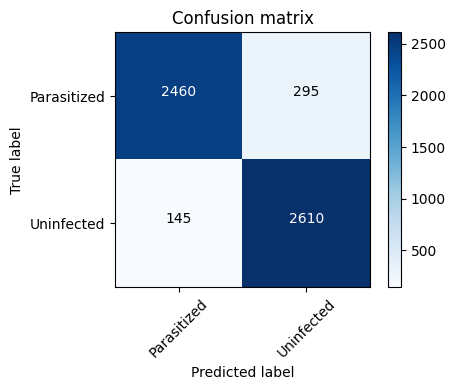

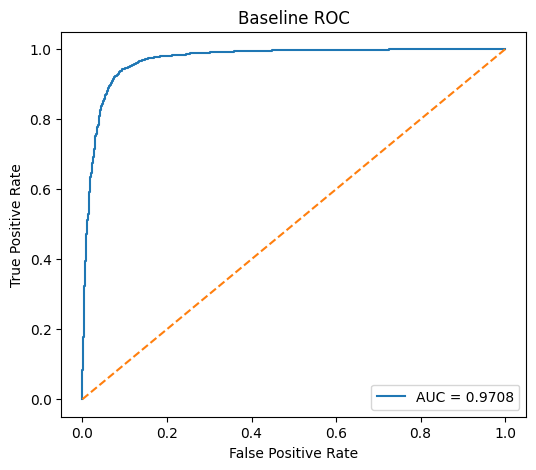


Classification report (baseline):

              precision    recall  f1-score   support

 Parasitized       0.94      0.89      0.92      2755
  Uninfected       0.90      0.95      0.92      2755

    accuracy                           0.92      5510
   macro avg       0.92      0.92      0.92      5510
weighted avg       0.92      0.92      0.92      5510



In [4]:
# Build baseline model
print("\n=== Building baseline model (VGG16 frozen) ===")
model_baseline = build_vgg16_baseline(input_shape=IMG_SIZE+(3,), dropout_rate=0.5)

# Print trainable flags for all layers
print('\nBaseline model layer trainable flags:')
for i, layer in enumerate(model_baseline.layers):
    print(f'{i}: {layer.name} -> trainable={layer.trainable}')

# Compile model
model_baseline.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                       loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_cb = callbacks.ModelCheckpoint('vgg16_baseline_best.h5', save_best_only=True, monitor='val_loss')
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train
EPOCHS = 10
history_baseline = model_baseline.fit(train_generator,
                                      epochs=EPOCHS,
                                      validation_data=val_generator,
                                      callbacks=[checkpoint_cb, earlystop_cb])

# Plot training history
plot_history(history_baseline, title_prefix='Baseline')

# Load best weights and evaluate
if os.path.exists('vgg16_baseline_best.h5'):
    model_baseline.load_weights('vgg16_baseline_best.h5')

report_baseline = evaluate_model(model_baseline, val_generator)
print('\nBaseline metrics:')
for k in ['accuracy','precision','recall','f1_score','roc_auc']:
    print(f'{k}: {report_baseline[k]:.4f}')

plot_confusion(report_baseline['y_true'], report_baseline['y_pred'], classes=list(CLASS_INDICES.keys()))
plot_roc(report_baseline['fpr'], report_baseline['tpr'], report_baseline['roc_auc'], title='Baseline ROC')

print('\nClassification report (baseline):\n')
print(classification_report(report_baseline['y_true'], report_baseline['y_pred'], target_names=list(CLASS_INDICES.keys())))


## Experiment B — Fine-tune (VGG16)

- Unfreeze last N layers of VGG16 (e.g., 4 layers) for fine-tuning.
- Lower learning rate to prevent large weight updates.
- Train with early stopping and checkpointing.



=== Building fine-tune model (unfreezing last 4 layers) ===

Fine-tune model layer trainable flags (last 4 layers should be True):
0: input_layer_1 -> trainable=False
1: block1_conv1 -> trainable=False
2: block1_conv2 -> trainable=False
3: block1_pool -> trainable=False
4: block2_conv1 -> trainable=False
5: block2_conv2 -> trainable=False
6: block2_pool -> trainable=False
7: block3_conv1 -> trainable=False
8: block3_conv2 -> trainable=False
9: block3_conv3 -> trainable=False
10: block3_pool -> trainable=False
11: block4_conv1 -> trainable=False
12: block4_conv2 -> trainable=False
13: block4_conv3 -> trainable=False
14: block4_pool -> trainable=False
15: block5_conv1 -> trainable=True
16: block5_conv2 -> trainable=True
17: block5_conv3 -> trainable=True
18: block5_pool -> trainable=True
19: global_average_pooling2d_1 -> trainable=True
20: dense_3 -> trainable=True
21: dropout_2 -> trainable=True
22: dense_4 -> trainable=True
23: dropout_3 -> trainable=True
24: dense_5 -> trainable=True

689/689 ━━━━━━━━━━━━━━━━━━━━ 179s 251ms/step - accuracy: 0.8034 - loss: 0.5746 - val_accuracy: 0.9309 - val_loss: 0.1913
Epoch 2/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9460 - loss: 0.1673

689/689 ━━━━━━━━━━━━━━━━━━━━ 172s 249ms/step - accuracy: 0.9460 - loss: 0.1673 - val_accuracy: 0.9417 - val_loss: 0.1595
Epoch 3/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 172s 250ms/step - accuracy: 0.9519 - loss: 0.1377 - val_accuracy: 0.9372 - val_loss: 0.1858
Epoch 4/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 172s 249ms/step - accuracy: 0.9558 - loss: 0.1284 - val_accuracy: 0.9419 - val_loss: 0.1598
Epoch 5/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 173s 251ms/step - accuracy: 0.9598 - loss: 0.1236 - val_accuracy: 0.9370 - val_loss: 0.1931
Epoch 6/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 173s 250ms/step - accuracy: 0.9590 - loss: 0.1160 - val_accuracy: 0.9452 - val_loss: 0.1951
Epoch 7/12
689/689 ━━━━━━━━━━━━━━━━━━━━ 173s 250ms/step - accuracy: 0.9593 - loss: 0.1197 - val_accuracy: 0.9443 - val_loss: 0.1696


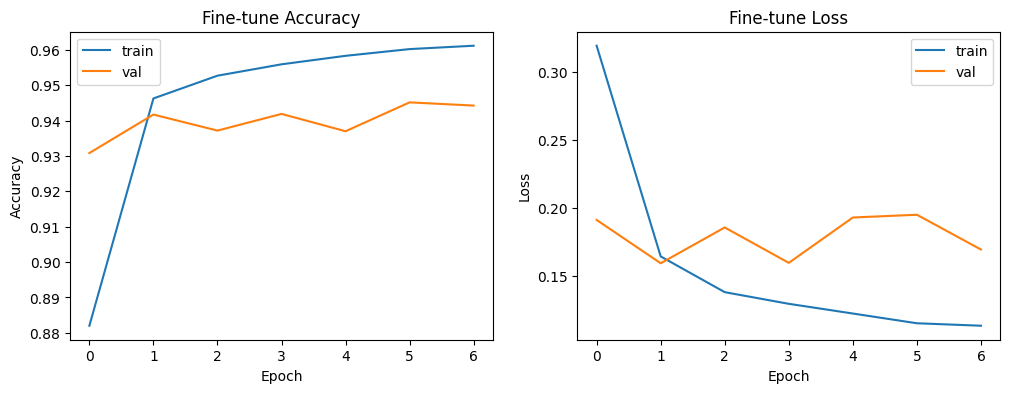

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step

Fine-tuned metrics:
accuracy: 0.9417
precision: 0.9103
recall: 0.9800
f1_score: 0.9439
roc_auc: 0.9852


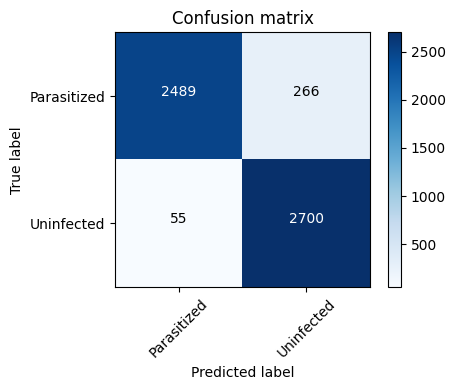

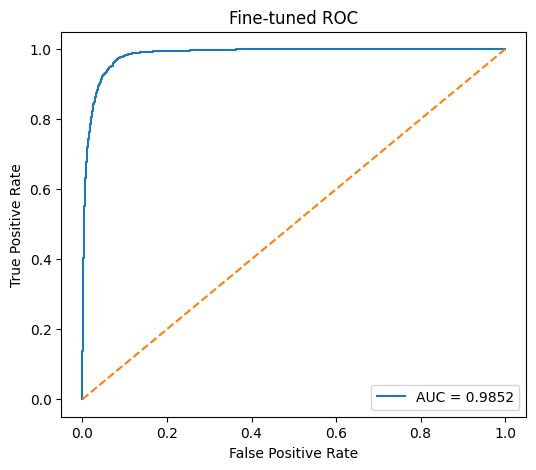


Classification report (fine-tuned):

              precision    recall  f1-score   support

 Parasitized       0.98      0.90      0.94      2755
  Uninfected       0.91      0.98      0.94      2755

    accuracy                           0.94      5510
   macro avg       0.94      0.94      0.94      5510
weighted avg       0.94      0.94      0.94      5510



In [5]:
# Fine-tune parameters
UNFREEZE_LAST_N = 4
print(f"\n=== Building fine-tune model (unfreezing last {UNFREEZE_LAST_N} layers) ===")
model_ft = build_vgg16_finetune(input_shape=IMG_SIZE+(3,), unfreeze_last_n=UNFREEZE_LAST_N, dropout_rate=0.5)

# Print trainable flags for all layers
print(f'\nFine-tune model layer trainable flags (last {UNFREEZE_LAST_N} layers should be True):')
for i, layer in enumerate(model_ft.layers):
    print(f'{i}: {layer.name} -> trainable={layer.trainable}')

# Compile
model_ft.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                 loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_cb2 = callbacks.ModelCheckpoint('vgg16_finetune_best.h5', save_best_only=True, monitor='val_loss')
earlystop_cb2 = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
EPOCHS_FT = 12
history_ft = model_ft.fit(train_generator,
                          epochs=EPOCHS_FT,
                          validation_data=val_generator,
                          callbacks=[checkpoint_cb2, earlystop_cb2])

plot_history(history_ft, title_prefix='Fine-tune')

# Load best weights and evaluate
if os.path.exists('vgg16_finetune_best.h5'):
    model_ft.load_weights('vgg16_finetune_best.h5')

report_ft = evaluate_model(model_ft, val_generator)
print('\nFine-tuned metrics:')
for k in ['accuracy','precision','recall','f1_score','roc_auc']:
    print(f'{k}: {report_ft[k]:.4f}')

plot_confusion(report_ft['y_true'], report_ft['y_pred'], classes=list(CLASS_INDICES.keys()))
plot_roc(report_ft['fpr'], report_ft['tpr'], report_ft['roc_auc'], title='Fine-tuned ROC')

print('\nClassification report (fine-tuned):\n')
print(classification_report(report_ft['y_true'], report_ft['y_pred'], target_names=list(CLASS_INDICES.keys())))


## Results Table & Best Model Selection

- Summarize both experiments in a table.
- Save the model with the highest F1-score as the best model.


In [6]:
results = pd.DataFrame([
    {
        'experiment': 'VGG16_baseline_frozen',
        'accuracy': report_baseline['accuracy'],
        'precision': report_baseline['precision'],
        'recall': report_baseline['recall'],
        'f1_score': report_baseline['f1_score'],
        'roc_auc': report_baseline['roc_auc']
    },
    {
        'experiment': f'VGG16_fine_tune_last_{UNFREEZE_LAST_N}',
        'accuracy': report_ft['accuracy'],
        'precision': report_ft['precision'],
        'recall': report_ft['recall'],
        'f1_score': report_ft['f1_score'],
        'roc_auc': report_ft['roc_auc']
    }
])

results.to_csv('vgg16_experiments_results.csv', index=False)
print('\nSaved results to vgg16_experiments_results.csv')
print('\nResults:')
print(results)

# Save best model based on F1-score
best_row = results.loc[results['f1_score'].idxmax()]
print('\nBest experiment based on F1-score:', best_row['experiment'])

if 'fine' in best_row['experiment']:
    model_ft.save('best_vgg16_model.h5')
    print('Saved best model (fine-tuned) to best_vgg16_model.h5')
else:
    model_baseline.save('best_vgg16_model.h5')
    print('Saved best model (baseline) to best_vgg16_model.h5')



Saved results to vgg16_experiments_results.csv

Results:
               experiment  accuracy  precision    recall  f1_score   roc_auc
0   VGG16_baseline_frozen  0.920145   0.898451  0.947368  0.922261  0.970817
1  VGG16_fine_tune_last_4  0.941742   0.910317  0.980036  0.943891  0.985151

Best experiment based on F1-score: VGG16_fine_tune_last_4
Saved best model (fine-tuned) to best_vgg16_model.h5


## Error Analysis — Misclassified Images

- Visualize a few misclassified validation images.
- Helps identify patterns or potential overfitting/underfitting.


Number of misclassified (chosen model): 321


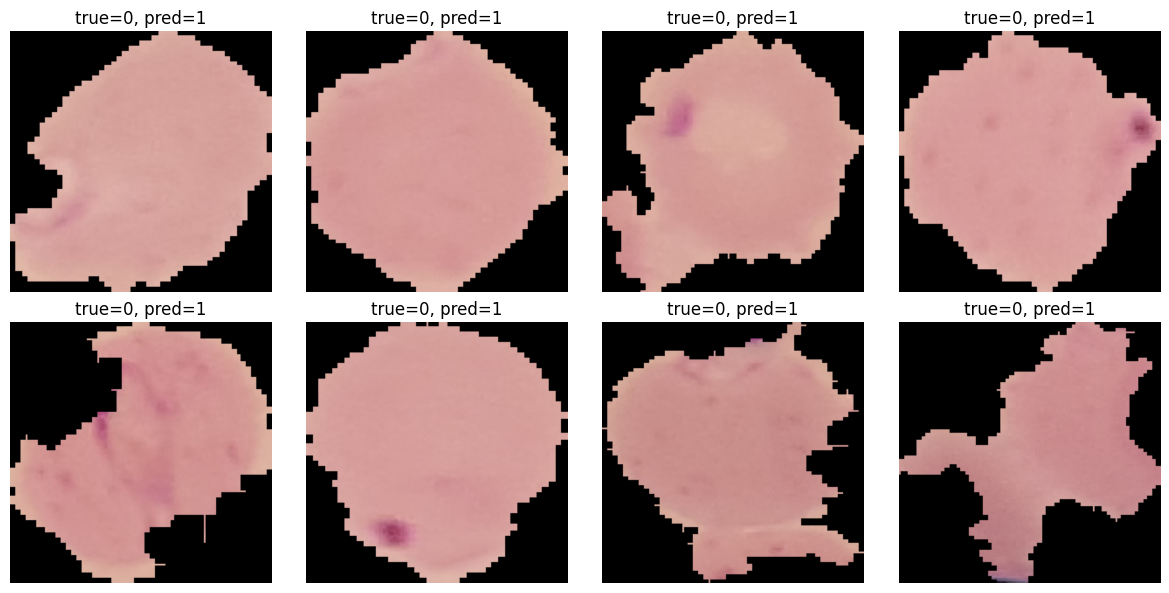

In [7]:
chosen_report = report_ft if report_ft['f1_score'] >= report_baseline['f1_score'] else report_baseline
mis_idx = np.where(chosen_report['y_pred'] != chosen_report['y_true'])[0]
print('Number of misclassified (chosen model):', len(mis_idx))

if len(mis_idx) > 0:
    plt.figure(figsize=(12,6))
    for i, idx in enumerate(mis_idx[:8]):
        ax = plt.subplot(2,4,i+1)
        img_path = val_generator.filepaths[idx]
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
        plt.imshow(img)
        plt.title(f'true={chosen_report["y_true"][idx]}, pred={chosen_report["y_pred"][idx]}')
        plt.axis('off')
    plt.tight_layout(); plt.show()
